In [13]:
# Imports
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Import data from drive
from google.colab import drive
drive.mount("/content/drive/")
%cd MyDrive/SPRING_2023_IW/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'MyDrive/SPRING_2023_IW/'
/content


In [30]:
# directory debugging code
%ls

COS398_IW.ipynb  database.sqlite  git.ipynb  README.md


In [79]:
# Create DB conn and pandas dataframes of tables
conn = sqlite3.connect("database.sqlite")
player_df = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes_df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
team_df = pd.read_sql_query("SELECT * FROM Team", conn)
team_attributes_df = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)
match_df = pd.read_sql_query("SELECT * FROM Match", conn)
league_df = pd.read_sql_query("SELECT * FROM League", conn)
country_df = pd.read_sql_query("SELECT * FROM Country", conn)

In [85]:
# Basic data cleaning
# Only get cols we could possibly care about
match_df = match_df[
    [
     'id', 'country_id', 'league_id', 'season', 'date', 'home_team_api_id',
     'away_team_api_id', 'home_player_1', 'home_player_2', 'home_player_3',
     'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
     'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
     'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
     'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
     'away_player_9', 'away_player_10', 'away_player_11'
    ]
].copy()
team_df.drop(labels=["team_fifa_api_id"], axis=1)

# Remove rows with missing values
player_df.dropna(inplace=True)
player_attributes_df.dropna(inplace=True) # drops 2713 rows, investigate which players and what year?
# team_df.dropna(inplace=True) (only fifa id missing, we don't care)
team_attributes_df.dropna(inplace=True) # drops some buildUpPlayDribbling
match_df.dropna(inplace=True)
league_df.dropna(inplace=True)
country_df.dropna(inplace=True)

# Only use data from the 2015-16 season
match_df = match_df[match_df.season.str.contains("2015/2016")]

In [96]:
### Exploratory Data Analysis

# Dimensions of data:
print(f"Player_df shape: {player_df.shape}")
print(f"Player_attributes_df shape: {player_attributes_df.shape}")
print(f"Team_df shape: {team_df.shape}")
print(f"Team_attributes_df shape: {team_attributes_df.shape}")
print(f"Match_df shape: {match_df.shape}")
print(f"League_df shape: {league_df.shape}")
print(f"Country_df shape: {country_df.shape}\n")

# Using match data, for each league, get its start date and end date for the 2015-16 season
season_min = match_df['date'].min(axis=0)
season_max = match_df['date'].max(axis=0)
print(f"Season min: {season_min}")
print(f"Season max: {season_max}\n")

# Merge the home and away teams from match_df on team_df
home_team_df = match_df.merge(team_df, how="inner", left_on='home_team_api_id', right_on='team_api_id')
away_team_df = match_df.merge(team_df, how="inner", left_on='away_team_api_id', right_on='team_api_id')

# Create a combined team df (matches + teams)
combined_team_df = pd.concat([home_team_df, away_team_df])
combined_team_df_nodups = combined_team_df.drop_duplicates(subset=['team_api_id'])
print(f"Combined_team_df shape: {combined_team_df.shape}")
print(f"Combined_team_df_nodups shape: {combined_team_df_nodups.shape}")

Player_df shape: (11060, 7)
Player_attributes_df shape: (180354, 42)
Team_df shape: (299, 5)
Team_attributes_df shape: (489, 25)
Match_df shape: (3018, 29)
League_df shape: (11, 3)
Country_df shape: (11, 2)

Season min: 2015-07-17 00:00:00
Season max: 2016-05-25 00:00:00

Combined_team_df shape: (6036, 34)
Combined_team_df_nodups shape: (188, 34)


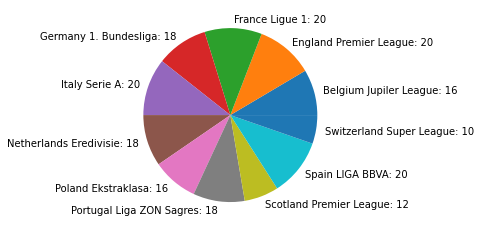

In [111]:
# Create a pie chart showing what leagues the teams played in
team_leagues_df = combined_team_df_nodups.merge(league_df, how="inner", left_on="league_id", right_on="id")
league_dict = {}
league_labels = []
league_sizes = []
for _, row in team_leagues_df.iterrows():
  league_name = row["name"]
  if league_name not in league_dict:
    league_dict[league_name] = 1
  else:
    league_dict[league_name] += 1
for label in league_dict:
  league_labels.append(label + ": " + str(league_dict[label]))
  league_sizes.append(league_dict[label])
fig, ax = plt.subplots()
ax.pie(league_sizes, labels=league_labels)
plt.show()

In [124]:
# Compile a list of players that played for each team during the 2015-16 season
team_league_df = combined_team_df.merge(league_df, how="inner", left_on="league_id", right_on="id")
team_dict = {} # Key: team_api_id, Value: info_dict
# print(team_league_df)

home_player_labels = [
  'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
  'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
  'home_player_9', 'home_player_10', 'home_player_11'
]
away_player_labels = [
  'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
  'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
  'away_player_9', 'away_player_10', 'away_player_11'
]

for _, row in team_league_df.iterrows():
  team_api_id = row['team_api_id']
  # For an unseen team, construct an info_dict
  if team_api_id not in team_dict:
    info_dict = {
        'team_short_name': row['team_short_name'],
        'team_long_name': row['team_long_name'],
        'league': row['name'],
        'players': set()
    }
    team_dict[team_api_id] = info_dict
  # Add home or away players, depending on which we looked at
  if team_api_id == row['home_team_api_id']:
    for home_player_label in home_player_labels:
      home_player_id = row[home_player_label]
      if home_player_id not in team_dict[team_api_id]['players']:
        team_dict[team_api_id]['players'].add(home_player_id)

  elif team_api_id == row['away_team_api_id']:
    for away_player_label in away_player_labels:
      away_player_id = row[away_player_label]
      if away_player_id not in team_dict[team_api_id]['players']:
        team_dict[team_api_id]['players'].add(away_player_id)
  else:
    print("ERROR! team_api_id doesn't match home or away!")

# Print how many players belong to each team, and some stats about the distribution

# And see the distribution within each league!

# For each player id in the player_dict, get the corresponding player's stats in JSON format

In [128]:
print(len(team_dict))
for team in team_dict:
  print(team)
  print(team_dict[team])
  print(len(team_dict[team]['players']))


188
9997
{'team_short_name': 'STT', 'team_long_name': 'Sint-Truidense VV', 'league': 'Belgium Jupiler League', 'players': {473859.0, 613260.0, 676625.0, 641042.0, 27157.0, 274456.0, 466589.0, 571681.0, 179365.0, 36522.0, 354475.0, 466480.0, 130738.0, 365244.0, 365245.0, 242243.0, 38341.0, 561611.0, 425426.0, 181842.0, 465746.0, 512726.0, 210392.0, 289248.0, 658786.0, 164323.0, 364779.0, 38382.0, 207603.0, 215415.0}}
30
8571
{'team_short_name': 'KOR', 'team_long_name': 'KV Kortrijk', 'league': 'Belgium Jupiler League', 'players': {206592.0, 166670.0, 156693.0, 581141.0, 478112.0, 70959.0, 179513.0, 305214.0, 209855.0, 181312.0, 157375.0, 192326.0, 40520.0, 37065.0, 94284.0, 371538.0, 294252.0, 280046.0, 478447.0, 38257.0, 317937.0, 95614.0}}
22
9987
{'team_short_name': 'GEN', 'team_long_name': 'KRC Genk', 'league': 'Belgium Jupiler League', 'players': {459658.0, 166675.0, 280083.0, 261654.0, 91929.0, 173730.0, 659493.0, 80678.0, 195448.0, 38969.0, 354494.0, 72259.0, 195782.0, 437329.0, 

In [ ]:
# Distribution of numerical variables, think about standardization

In [ ]:
# (further?) Data cleaning and feature engineering (including Principal Component Analysis)
# Then go into data preparation and research models!